<a href="https://colab.research.google.com/github/XiwenJia/RNA-Seq-DAP-Project-/blob/main/DAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mechanize
!pip install seaborn
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure
import scipy.stats as stats
import pylab
from itertools import permutations
from collections import Counter
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.4/110.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/My\ Drive/Sequencing/FASTQ

/content/drive/My Drive/Sequencing/FASTQ


In [ ]:
pwd

'/content/drive/My Drive/Sequencing/FASTQ'

## Data Preprocessing

### Quality Score Filter

In [ ]:
def filter_by_quality_and_report_percentage(input_fastq, output_fastq, threshold=30):
    filtered_records = []
    total_records = 0

    for record in SeqIO.parse(input_fastq, "fastq"):
        total_records += 1
        # Convert ASCII characters to Phred quality scores
        # and check if all scores are above the threshold
        if all(score >= threshold for score in record.letter_annotations["phred_quality"]):
            filtered_records.append(record)

    SeqIO.write(filtered_records, output_fastq, "fastq")

    # Calculate and print the percentage of reads that passed the filter
    percentage_passing_filter = (len(filtered_records) / total_records) * 100 if total_records > 0 else 0
    print(f"Filtered {len(filtered_records)} out of {total_records} records with quality score >= {threshold}.")
    print(f"Percentage of reads that passed the quality filter: {percentage_passing_filter:.2f}%")

In [ ]:
# Load the control for AUCG
input_fastq_R1 = "XJb1-1_S1_L001_R1_001.fastq"  # Update this path to your R1 FASTQ file
output_fastq_R1 = "XJb1-1_S1_L001_R1_001_f1.fastq"  # Path for the high-quality R1 output file
input_fastq_R2 = "XJb1-1_S1_L001_R2_001.fastq"  # Update this path to your R1 FASTQ file
output_fastq_R2 = "XJb1-1_S1_L001_R2_001_f1.fastq"  # Path for the high-quality R1 output file

filter_by_quality_and_report_percentage(input_fastq_R1, output_fastq_R1)
filter_by_quality_and_report_percentage(input_fastq_R2, output_fastq_R2)

Filtered 512189 out of 512189 records with quality score >= 30.
Percentage of reads that passed the quality filter: 100.00%
Filtered 512189 out of 512189 records with quality score >= 30.
Percentage of reads that passed the quality filter: 100.00%


In [ ]:
# Load the control for DUCG
input_fastq_R1 = "XJb1-5_S5_L001_R1_001.fastq"  # Update this path to your R1 FASTQ file
output_fastq_R1 = "XJb1-5_S5_L001_R1_001_f1.fastq"  # Path for the high-quality R1 output file
input_fastq_R2 = "XJb1-5_S5_L001_R2_001.fastq"  # Update this path to your R1 FASTQ file
output_fastq_R2 = "XJb1-5_S5_L001_R2_001_f1.fastq"  # Path for the high-quality R1 output file

filter_by_quality_and_report_percentage(input_fastq_R1, output_fastq_R1)
filter_by_quality_and_report_percentage(input_fastq_R2, output_fastq_R2)

Filtered 1059020 out of 1059020 records with quality score >= 30.
Percentage of reads that passed the quality filter: 100.00%
Filtered 1059020 out of 1059020 records with quality score >= 30.
Percentage of reads that passed the quality filter: 100.00%


In [ ]:
# Example usage
input_fastq_R1 = "XJb2-2_S2_L001_R1_000.fastq"  # Update this path to your R1 FASTQ file
output_fastq_R1 = "XJb2-2_S2_L001_R1_000_f1.fastq"  # Path for the high-quality R1 output file
input_fastq_R2 = "XJb2-2_S2_L001_R2_000.fastq"  # Update this path to your R1 FASTQ file
output_fastq_R2 = "XJb2-2_S2_L001_R2_000_f1.fastq"  # Path for the high-quality R1 output file

filter_by_quality_and_report_percentage(input_fastq_R1, output_fastq_R1)
filter_by_quality_and_report_percentage(input_fastq_R2, output_fastq_R2)

Filtered 1858274 out of 1858274 records with quality score >= 30.
Percentage of reads that passed the quality filter: 100.00%
Filtered 1858274 out of 1858274 records with quality score >= 30.
Percentage of reads that passed the quality filter: 100.00%


### R1 and R2 Read Check

In [ ]:
def filter_reads_and_store(input_r1_fastq, input_r2_fastq, output_r1_fastq, output_r2_fastq):
    prefix_r1 = 'TCTA'
    fix1_r1 = 'GCATGCGACTAAACGTCGCATGC'
    fix2_r1 = 'AGATCGGAAGAGCACACGTCTGA'
    prefix_r2 = 'TAGA'
    fix1_r2 = 'GCATGCGACGTTTAGTCGCATGC'

    # Initialize lists to store filtered SeqRecord objects
    filtered_r1_records = []
    filtered_r2_records = []

    # Read R1 and R2 files and filter based on conditions
    r1_records = list(SeqIO.parse(input_r1_fastq, "fastq"))
    r2_records = list(SeqIO.parse(input_r2_fastq, "fastq"))

    # Ensure both files have the same number of records
    assert len(r1_records) == len(r2_records), "R1 and R2 files contain a different number of records."

    for r1_record, r2_record in zip(r1_records, r2_records):
        sequence_r1 = str(r1_record.seq)
        sequence_r2 = str(r2_record.seq)

        # Check conditions for R1
        if sequence_r1.startswith(prefix_r1) and fix1_r1 in sequence_r1 and fix2_r1 in sequence_r1:
            # Check conditions for R2
            if prefix_r2 in sequence_r2 and fix1_r2 in sequence_r2:
                # Add records to the filtered lists
                filtered_r1_records.append(r1_record)
                filtered_r2_records.append(r2_record)

    # Write filtered records to new FASTQ files
    SeqIO.write(filtered_r1_records, output_r1_fastq, "fastq")
    SeqIO.write(filtered_r2_records, output_r2_fastq, "fastq")
    n_retained_reads = len(filtered_r1_records)
    print(f"Filtered and stored {n_retained_reads} R1 and R2 reads.")

    return n_retained_reads


In [ ]:
# Control sample read check for AUCG, control
input_r1_fastq = "XJb1-1_S1_L001_R1_001_f1.fastq"  # Replace with the actual file path
input_r2_fastq = "XJb1-1_S1_L001_R2_001_f1.fastq"  # Replace with the actual file path
output_r1_fastq = "XJb1-1_S1_L001_R1_001_f2.fastq"  # Replace with the desired output file pafth
output_r2_fastq = "XJb1-1_S1_L001_R2_001_f2.fastq"  # Replace with the desired output file path

n_retained_reads_ACUG = filter_reads_and_store(input_r1_fastq, input_r2_fastq, output_r1_fastq, output_r2_fastq)

Filtered and stored 264717 R1 and R2 reads.


In [ ]:
# Control sample read check for DUCG, control
input_r1_fastq = "XJb1-5_S5_L001_R1_001_f1.fastq"  # Replace with the actual file path
input_r2_fastq = "XJb1-5_S5_L001_R2_001_f1.fastq"  # Replace with the actual file path
output_r1_fastq = "XJb1-5_S5_L001_R1_001_f2.fastq"  # Replace with the desired output file path
output_r2_fastq = "XJb1-5_S5_L001_R2_001_f2.fastq"  # Replace with the desired output file path

n_retained_reads_DUCG = filter_reads_and_store(input_r1_fastq, input_r2_fastq, output_r1_fastq, output_r2_fastq)

Filtered and stored 653162 R1 and R2 reads.


In [ ]:
# Example usage
input_r1_fastq = "XJb2-2_S2_L001_R1_000_f1.fastq"  # Replace with the path to your R1 FASTQ file
input_r2_fastq = "XJb2-2_S2_L001_R2_000_f1.fastq"  # Replace with the path to your R2 FASTQ file
output_r1_fastq = "XJb2-2_S2_L001_R1_000_f2.fastq"  # Replace with the desired path for filtered R1 FASTQ file
output_r2_fastq = "XJb2-2_S2_L001_R2_000_f2.fastq"  # Replace with the desired path for filtered R2 FASTQ file

n_retained_reads_s2 = filter_reads_and_store(input_r1_fastq, input_r2_fastq, output_r1_fastq, output_r2_fastq)

Filtered and stored 661540 R1 and R2 reads.


### FASTQ trimming

In [ ]:
def trim_and_extract_sequence_pairs(input_r1_fastq):
    prefix = 'TCTA'
    fix1 = 'GCATGCGACTAAACGTCGCATGC'
    fix2 = 'AGATCGGAAGAGCACACGTCTGA'

    template_product_pairs = []

    for record in SeqIO.parse(input_r1_fastq, "fastq"):
        sequence = str(record.seq)
        if prefix in sequence and fix1 in sequence and fix2 in sequence:
            # Locate the fix1 and fix2 sequences
            start_fix1 = sequence.find(fix1) + len(fix1)
            end_fix2 = sequence.find(fix2)

            # Extract the template and product sequences
            template_sequence = sequence[len(prefix):sequence.find(fix1)]
            product_sequence = sequence[start_fix1:end_fix2]

            # Reverse the order of the template sequence
            reversed_template_sequence = template_sequence[::-1]

            # Store the template-product pair as a tuple
            template_product_pairs.append((reversed_template_sequence, product_sequence))

    return template_product_pairs

#### Trimming

In [ ]:
# For standard AUCG system (control)
input_r1_fastq_1 = "XJb1-1_S1_L001_R1_001_f2.fastq"
template_product_pairs_1 = trim_and_extract_sequence_pairs(input_r1_fastq_1)
print(f"Extracted {len(template_product_pairs_1)} template-product pairs.")

Extracted 264717 template-product pairs.


In [ ]:
# For standard DUCG system (control)
input_r1_fastq_2 = "XJb1-5_S5_L001_R1_001_f2.fastq"
template_product_pairs_2 = trim_and_extract_sequence_pairs(input_r1_fastq_2)
print(f"Extracted {len(template_product_pairs_2)} template-product pairs.")

Extracted 653162 template-product pairs.


In [ ]:
# For sample 2-2
input_r1_fastq_s2 = "XJb2-2_S2_L001_R1_000_f2.fastq"
template_product_pairs_s2 = trim_and_extract_sequence_pairs(input_r1_fastq_s2)
print(f"Extracted {len(template_product_pairs_s2)} template-product pairs.")

Extracted 661540 template-product pairs.


In [ ]:
template_product_pairs_s2;

#### Filtering tuples for two controls - AUCG and DUCG systems

In [ ]:
# Only keep the tuple pairs where the template sequence has length 6 and the product sequence is empty
filtered_pairs_1 = [pair for pair in template_product_pairs_1 if len(pair[0]) == 6 and len(pair[1]) == 0]
retained_percentage_1 = len(filtered_pairs_1)/len(template_product_pairs_1)*100
print(f"Percentage of retained filtered pars for the template AUCG: {retained_percentage_1:.2f}%")
#filtered_pairs = [pair for pair in template_product_pairs if len(pair[0]) == 6]

Percentage of retained filtered pars for the template AUCG: 95.53%


In [ ]:
# Only keep the tuple pairs where the template sequence has length 6 and the product sequence is empty
filtered_pairs_2 = [pair for pair in template_product_pairs_2 if len(pair[0]) == 6 and len(pair[1]) == 0]
retained_percentage_2 = len(filtered_pairs_2)/len(template_product_pairs_2)*100
print(f"Percentage of retained filtered pars for the template DUCG: {retained_percentage_2:.2f}%")
#filtered_pairs = [pair for pair in template_product_pairs if len(pair[0]) == 6]

Percentage of retained filtered pars for the template DUCG: 94.61%


In [ ]:
# split the filtered pairs into a list of template sequences and product sequences
filtered_template_1 = [item[0] for item in filtered_pairs_1]
filtered_product_1 = [item[1] for item in filtered_pairs_1]
filtered_template_2 = [item[0] for item in filtered_pairs_2]
filtered_product_2 = [item[1] for item in filtered_pairs_2]

#### Filtering tuples for samples

In [ ]:
# Only keep the tuple pairs where the template sequence has length 6 and the product sequence has length 0-6
# The product sequence for the sample tuple pairs can be of variable length, including an empty string
filtered_pairs_s2 = [pair for pair in template_product_pairs_s2 if len(pair[0]) == 6 and 0 <= len(pair[1]) <= 6]
retained_s2 = len(filtered_pairs_s2)
retained_percentage_s2 = len(filtered_pairs_s2)/len(template_product_pairs_s2)*100
print('Final number of retained filtered pairs', retained_s2)
print(f"Percentage of retained filtered pairs for s2: {retained_percentage_s2:.2f}%")

Final number of retained filtered pairs 633720
Percentage of retained filtered pairs for s2: 95.79%


In [ ]:
filtered_template_s2 = [item[0] for item in filtered_pairs_s2]
filtered_product_s2 = [item[1] for item in filtered_pairs_s2]

In [ ]:
len(filtered_product_s2)

633720

In [ ]:
filtered_template_s2[0:10]

['CGACGA',
 'TTTCTC',
 'TGTTTG',
 'TTACTA',
 'TTCGAA',
 'GACATG',
 'TCACTG',
 'TCATCG',
 'TTTCGG',
 'ACAGCA']

In [ ]:
filtered_product_s2[0:10]

['', '', 'A', '', '', '', '', '', '', 'T']

In [ ]:
retained_s2

633720

## Nucleobase Distrubtion and Normalization Factor for the Control (AUCG or DUCG)

In [ ]:
def distribution_normalization_heatmap(sequences, str):
    # Determine sequence length based on the first sequence
    seq_length = len(sequences[0])

    # Initialize counters for each position in the sequences
    counters = [Counter() for _ in range(seq_length)]

    # Populate the counters with nucleobases at each position
    for seq in sequences:
        for i, nucleobase in enumerate(seq):
            counters[i][nucleobase] += 1

    # Convert counters to a DataFrame and transpose it for the heatmap
    df = pd.DataFrame(counters).transpose()

    # Normalize the counts to get frequencies
    df_normalized = df.div(df.sum()).fillna(0)

    # Rename index and desired order based on title_str condition
    if str == 'DUCG':
        df_normalized.rename(index={'T': 'U', 'A':'D'}, inplace=True)
        desired_order = ['D', 'C', 'G', 'U']
    else:
        df_normalized.rename(index={'T': 'U'}, inplace=True)
        desired_order = ['A', 'C', 'G', 'U']


    # Reorder the DataFrame rows
    df_normalized = df_normalized.loc[desired_order]

    # Set column names to represent positions
    df_normalized.columns = [f'{i+1}' for i in range(seq_length)]

    # Compute the normalization factor
    df_n_factor = 0.25 / df_normalized

    # Display the heatmap for nucleobase distribution
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(df_normalized, annot=True, cmap='Blues', fmt=".2f", cbar_kws={'label': 'Frequency'})
    plt.title('Nucleobase Distribution\n'+str, fontweight = 'bold', fontsize = 30)
    plt.xlabel('Sequence Position',fontweight = 'bold', fontsize = 20)
    plt.ylabel('Nucleobase',fontweight = 'bold', fontsize = 20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.show()

    # Display the heatmap for normalization factor
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(df_n_factor, annot=True, cmap='Blues', fmt=".2f", cbar_kws={'label': 'Frequency'})
    plt.title('Normalization Factor\n'+str, fontweight = 'bold', fontsize = 30)
    plt.xlabel('Sequence Position',fontweight = 'bold', fontsize = 20)
    plt.ylabel('Nucleobase',fontweight = 'bold', fontsize = 20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.show()

    # Return the DataFrame for potential further use
    return df_normalized, df_n_factor

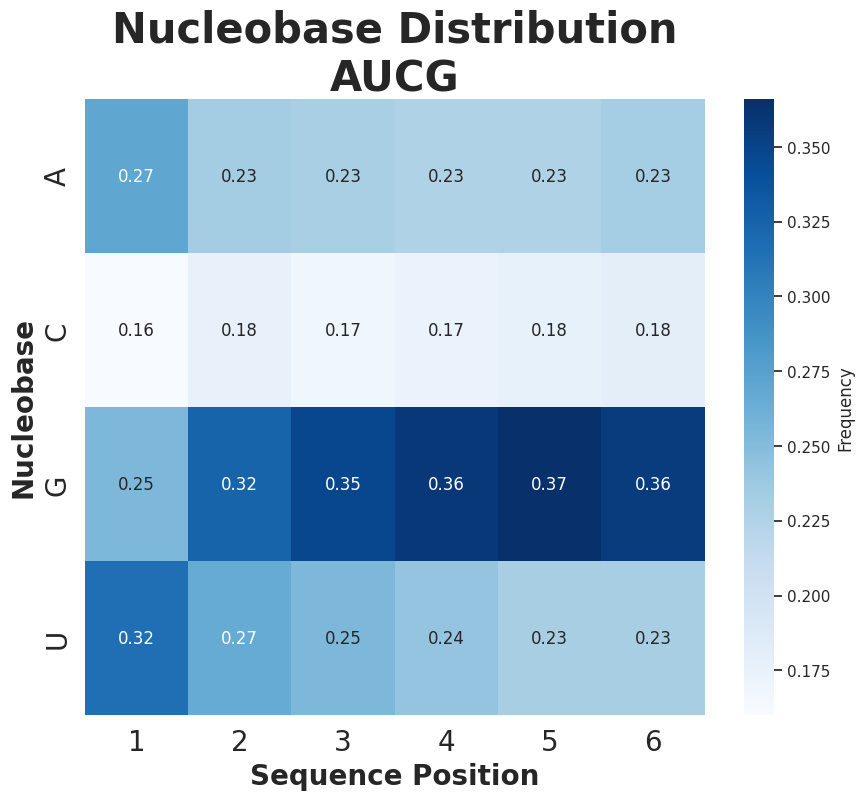

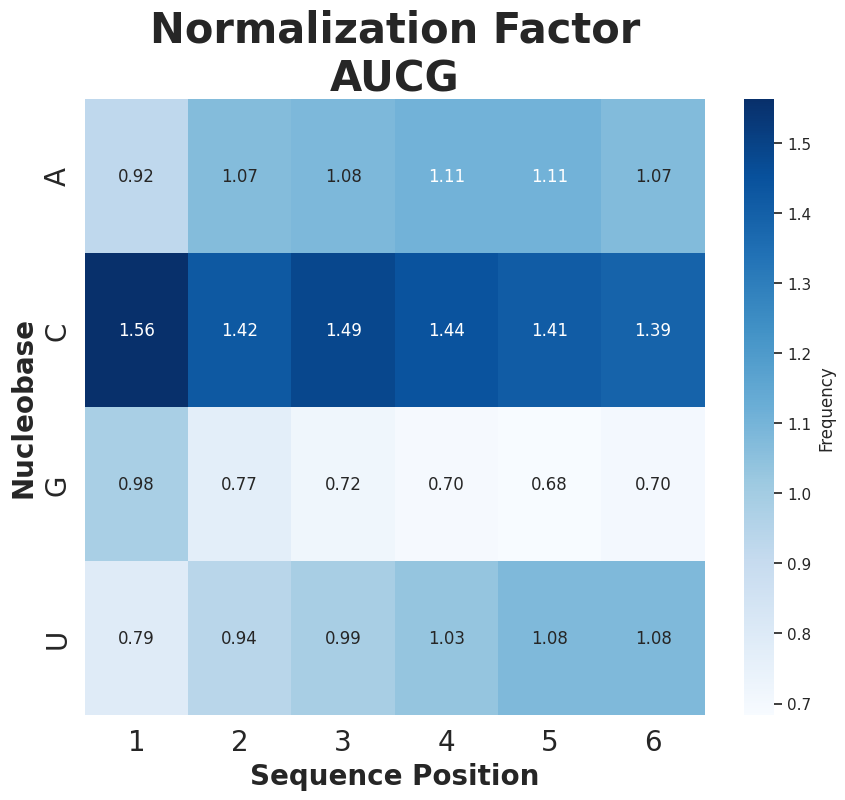

nucleobase distribution
           1         2         3         4         5         6
A  0.270716  0.233918  0.230470  0.225863  0.225828  0.232807
C  0.160005  0.175700  0.168155  0.173323  0.176870  0.180120
G  0.253836  0.324609  0.347979  0.358750  0.365907  0.355511
U  0.315443  0.265774  0.253397  0.242064  0.231395  0.231561
normalization factor
           1         2         3         4         5         6
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628


In [ ]:
# AUCG control
sequences = filtered_template_1

# Calculate the distribution, normalization factor and display the heatmap
df_distribution_AUCG, df_n_factor_AUCG = distribution_normalization_heatmap(sequences,'AUCG')
print('nucleobase distribution\n', df_distribution_AUCG)
print ('normalization factor\n', df_n_factor_AUCG)

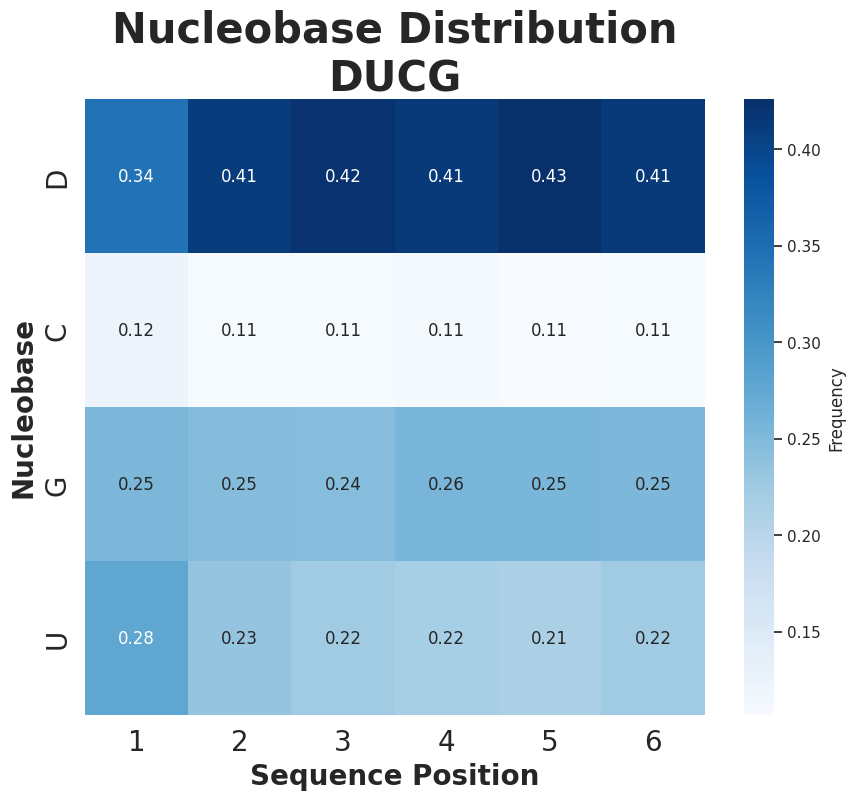

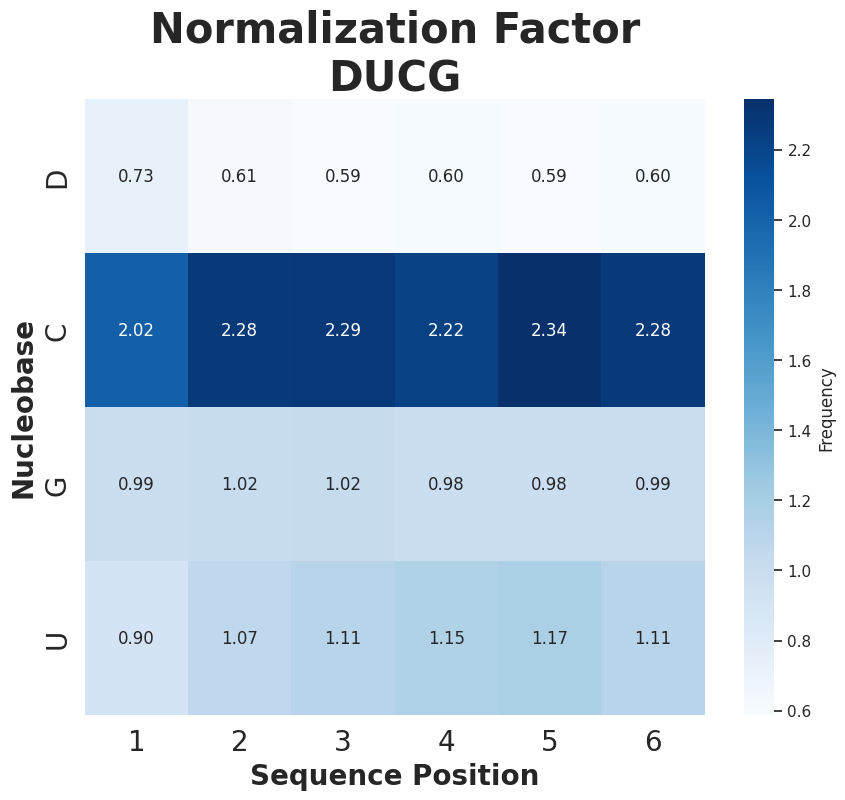

nucleobase distribution
           1         2         3         4         5         6
D  0.344642  0.410147  0.422217  0.414344  0.425976  0.414250
C  0.123758  0.109671  0.109244  0.112593  0.106659  0.109635
G  0.253174  0.245512  0.244234  0.255278  0.253939  0.251635
U  0.278425  0.234670  0.224306  0.217785  0.213426  0.224479
normalization factor
           1         2         3         4         5         6
D  0.725390  0.609538  0.592113  0.603363  0.586888  0.603500
C  2.020064  2.279550  2.288464  2.220383  2.343910  2.280290
G  0.987463  1.018280  1.023610  0.979326  0.984487  0.993502
U  0.897907  1.065324  1.114549  1.147922  1.171369  1.113689


In [ ]:
# DUCG control
sequences = filtered_template_2

# Calculate the distribution, normalization factor and display the heatmap
df_distribution_DUCG, df_n_factor_DUCG = distribution_normalization_heatmap(sequences,'DUCG')
print('nucleobase distribution\n', df_distribution_DUCG)
print ('normalization factor\n', df_n_factor_DUCG)

In [ ]:
df_n_factor_AUCG

,1,2,3,4,5,6
A,0.923476,1.068750,1.084740,1.106865,1.107039,1.073851
C,1.562451,1.422884,1.486725,1.442394,1.413468,1.387961
G,0.984889,0.770158,0.718435,0.696864,0.683233,0.703212
U,0.792536,0.940650,0.986595,1.032786,1.080403,1.079628


In [ ]:
# This function enables transformation of the original dataframe files from the controls (AUCG and DUCG systems)
# Functionalities include padding (n: pad how many times) and reversing order of the rows

def n_factor_transform(df, n, reversed_rows=False):
    """
    Duplicate each row in the DataFrame twice more, resulting in each row appearing three times in total,
    while keeping the index of each row the same.

    Parameters:
    - df: A pandas DataFrame.

    Returns:
    - A new pandas DataFrame with each original row duplicated twice more and the same index preserved.
    """
    duplicated_rows = []

    # Iterate through each row in the DataFrame and duplicate it
    for index, row in df.iterrows():
        # Append the row three times to the list
        for _ in range(n):
            duplicated_rows.append(row)

    # Convert the list of rows back into a DataFrame
    duplicated_df = pd.DataFrame(duplicated_rows).reset_index(drop=True)

    # Reset the index to match the original DataFrame's index repeated for each row
    duplicated_df.index = np.repeat(df.index, n)

    if reversed_rows == True:
      duplicated_df = duplicated_df.iloc[::-1]

    return duplicated_df

#### Normalization factor tables for correcting complementary incorporation - nucleobase distribution

In [ ]:
# In order to correct (normalize) the complementary product region, first need to reindex normalization table
# In this way, we use the correct normalization factor to normalize the complementary product region
# For example, we use the normalization factor for 'U' to normalize 'A' in the complementary product

df_n_factor_AUCG_reindexed = n_factor_transform(df_n_factor_AUCG, 1, True)
df_n_factor_DUCG_reindexed = n_factor_transform(df_n_factor_DUCG, 1, True)
print(df_n_factor_AUCG_reindexed)
print(df_n_factor_DUCG_reindexed)

          1         2         3         4         5         6
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
          1         2         3         4         5         6
U  0.897907  1.065324  1.114549  1.147922  1.171369  1.113689
G  0.987463  1.018280  1.023610  0.979326  0.984487  0.993502
C  2.020064  2.279550  2.288464  2.220383  2.343910  2.280290
D  0.725390  0.609538  0.592113  0.603363  0.586888  0.603500


#### Normalization factor tables for correcting complementary incorporation - bridged dinucleotides distribution

In [ ]:
padded_df_n_factor_AUCG_reindexed = n_factor_transform(df_n_factor_AUCG, 4, True)
padded_df_n_factor_DUCG_reindexed = n_factor_transform(df_n_factor_DUCG, 4, True)
print(padded_df_n_factor_AUCG_reindexed)
print(padded_df_n_factor_DUCG_reindexed)

          1         2         3         4         5         6
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
A  0.923

#### Normalization factor tables for correcting mismatched incorporation

In [ ]:
# pad the normalization factor pandas dataframe to be used in multiplying with the mismatched incorporation table

# AUCG
padded_df_AUCG = n_factor_transform(df_n_factor_AUCG, 3)
print (padded_df_AUCG)

# DUCG
padded_df_DUCG = n_factor_transform(df_n_factor_DUCG, 3)
print (padded_df_DUCG)

          1         2         3         4         5         6
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
A  0.923476  1.068750  1.084740  1.106865  1.107039  1.073851
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
C  1.562451  1.422884  1.486725  1.442394  1.413468  1.387961
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
G  0.984889  0.770158  0.718435  0.696864  0.683233  0.703212
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
U  0.792536  0.940650  0.986595  1.032786  1.080403  1.079628
          1         2         3         4         5         6
D  0.725390  0.609538  0.592113  0.603363  0.586888  0.603500
D  0.725390  0.609538  0.592113  0.603363  0.586888  0.603500
D  0.725

## Grouping the products as complementary, mismatched, or unincorporated

In [ ]:
#second way to categorizing complementary/mismatched pairs

def categorize_pairs(pairs):
    # Define the complement mapping for DNA nucleobases
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    # Initialize categories
    categories = {'complementary': [], 'mismatched': [], 'unincorporation': []}

    for template, product in pairs:
        if product == "":  # Check for unincorporation
            categories['unincorporation'].append((template, product))
            continue

        # Check for mismatches first
        is_mismatch = False
        for t_base, p_base in zip(template, product):
            if complement.get(t_base, '') != p_base:  # If any position doesn't match its complement
                is_mismatch = True
                categories['mismatched'].append((template, product))
                break  # No need to check further if a mismatch is found

        # If no mismatches were found, check for a complete complementary match
        if not is_mismatch:
            is_complementary = all(complement.get(t, '') == p for t, p in zip(template, product))
            if is_complementary:
                categories['complementary'].append((template, product))
            else:
                categories['mismatched'].append((template, product))

    return categories

In [ ]:
# Run the function
categorized_pairs_s2 = categorize_pairs(filtered_pairs_s2)

# Summarize the results
for category, pairs in categorized_pairs_s2.items():
    print(f"{category.capitalize()}: {len(pairs)} pairs")

Complementary: 147028 pairs
Mismatched: 68952 pairs
Unincorporation: 417740 pairs


In [ ]:
# compute the overall mismatch percentage
# mismatch percentage = mismatched incorporation / (complementary + mismatched incorporation)

# for sample 2-2
mismatch_percentage_s2 = len(categorized_pairs_s2['mismatched'])/(len(categorized_pairs_s2['complementary']) + len(categorized_pairs_s2['mismatched']))*100
print(f"overall mismatch percentage for sample 2-2 is: {mismatch_percentage_s2:.1f}%")

overall mismatch percentage for sample 2-2 is: 31.9%


In [ ]:
categorized_pairs_s2['complementary'][0]

('TGTTTG', 'A')

## Output the position-dependent complementary and mismatched frequency

In [ ]:
def pairs_length_distribution(pairs, total_reads):
    # Define the complement mapping for DNA nucleobases
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    # Initialize a DataFrame for lengths 1 through 6
    distribution_df = pd.DataFrame({
        'Length': range(1, 7),
        'Complementary_Count': 0,
        'Complementary_Frequency': 0.0,
        'Mismatched_Count': 0,
        'Mismatched_Frequency': 0.0
    }).set_index('Length')

    # Process complementary pairs
    for template, product in pairs['complementary']:
        length = len(product)
        if length in distribution_df.index:
            distribution_df.loc[length, 'Complementary_Count'] += 1

    # Process mismatched pairs
    for template, product in pairs['mismatched']:
        length = len(product)
        if length in distribution_df.index:
            distribution_df.loc[length, 'Mismatched_Count'] += 1

    # Calculate the frequency of complementary and mismatched pairs at each product position
    distribution_df['Complementary_Frequency'] = distribution_df['Complementary_Count'] / total_reads
    distribution_df['Mismatched_Frequency'] = distribution_df['Mismatched_Count'] / total_reads

    return distribution_df.reset_index()

In [ ]:
#run for sample 2-2
pairs_s2 = categorized_pairs_s2

# Get the distribution DataFrame
distribution_df_s2 = pairs_length_distribution(pairs_s2, retained_s2)

# Display the DataFrame
distribution_df_s2

,Length,Complementary_Count,Complementary_Frequency,Mismatched_Count,Mismatched_Frequency
0,1,96625,0.152473,48272,0.076172
1,2,25659,0.040489,8584,0.013545
2,3,12488,0.019706,5491,0.008665
3,4,6478,0.010222,3621,0.005714
4,5,4375,0.006904,1992,0.003143
5,6,1403,0.002214,992,0.001565


## Yield and fidelity plots - with cumulative sum calculations

In [ ]:
def pairs_length_distribution(pairs, total_reads):
    # Define the maximum length we are considering
    max_length = 6

    # Initialize a DataFrame for lengths 1 through max_length with zeros
    distribution_df = pd.DataFrame({
        'Length': range(1, max_length + 1),
        'Total_Count': [0] * max_length,
        'Mismatched_Count': [0] * max_length,
    }).set_index('Length')

    # Process all pairs to accumulate total and mismatched counts
    for category, category_pairs in pairs.items():
        for template, product in category_pairs:
            length = len(product)
            if 1 <= length <= max_length:
                distribution_df.loc[length, 'Total_Count'] += 1
                if category == 'mismatched':
                    distribution_df.loc[length, 'Mismatched_Count'] += 1

    # Apply cumulative sum only to total counts in reverse order
    distribution_df['Total_Count'] = distribution_df['Total_Count'][::-1].cumsum()[::-1]


    # Calculate complementary count using specified formula
    distribution_df['Complementary_Count'] = distribution_df['Total_Count'] - distribution_df['Mismatched_Count']

    # Calculate frequencies based on total reads
    distribution_df['Complementary_Frequency'] = distribution_df['Complementary_Count'] / total_reads
    distribution_df['Mismatched_Frequency'] = distribution_df['Mismatched_Count'] / total_reads

    return distribution_df.reset_index()

In [ ]:
pairs_s2 = categorized_pairs_s2

# Get the distribution DataFrame for complementary and mismatched pairs
distribution_df_s2 = pairs_length_distribution(pairs_s2, retained_s2)

# Display the DataFrame
distribution_df_s2

,Length,Total_Count,Mismatched_Count,Complementary_Count,Complementary_Frequency,Mismatched_Frequency
0,1,215980,48272,167708,0.264641,0.076172
1,2,71083,8584,62499,0.098622,0.013545
2,3,36840,5491,31349,0.049468,0.008665
3,4,18861,3621,15240,0.024048,0.005714
4,5,8762,1992,6770,0.010683,0.003143
5,6,2395,992,1403,0.002214,0.001565


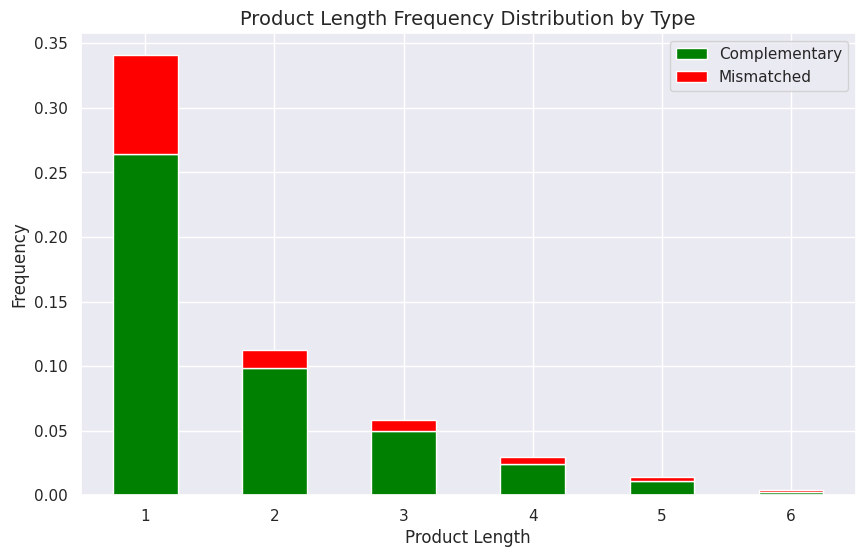

In [ ]:
# Generate stacked barplots indicating position-dependent complementary and mismatched incorporation

# Example DataFrame setup
df = distribution_df_s2

df.set_index('Length', inplace=True)

# Plotting frequencies using a stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each category
colors = ['green', 'red']

# Stacked bar plot for frequencies
df[['Complementary_Frequency', 'Mismatched_Frequency']].plot(kind='bar', stacked=True, ax=ax, color=colors)

# Customization
ax.set_xlabel('Product Length', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Product Length Frequency Distribution by Type', fontsize=14)
ax.legend(['Complementary', 'Mismatched'])

plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal
plt.show()

## Complementary product base distribution

In [ ]:
# Only focus on the complementary set
# First output a table indicating counts of each nucleobase (A, U, C, G) at each position

def extract_position_dependent_counts_to_df(categorized_pairs):
    # Initialize a structure to hold counts for each nucleobase at each position
    nucleobase_counts = defaultdict(lambda: defaultdict(int))

    # Maximum sequence length expected
    max_length = 6
    positions = range(1, max_length + 1)
    nucleobases = ['A', 'C', 'G', 'T']

    for _, product in categorized_pairs:
        for position, nucleobase in enumerate(product, start=1):
            if position <= max_length:
                nucleobase_counts[nucleobase][position] += 1

    # Initialize a DataFrame with zeros for all nucleobases and positions
    df_counts = pd.DataFrame(0, index=nucleobases, columns=positions)

    # Fill the DataFrame with the collected counts
    for nucleobase, pos_counts in nucleobase_counts.items():
        for position, count in pos_counts.items():
            df_counts.at[nucleobase, position] = count

    df_counts.rename(index={'T': 'U'}, inplace=True)
    desired_order = ['A', 'C', 'G', 'U']

    return df_counts

In [ ]:
# Example usage with categorized_pairs
categorized_pairs = categorized_pairs_s2['complementary']

# Extract position-dependent counts and convert to DataFrame
df_nucleobase_counts_s2 = extract_position_dependent_counts_to_df(categorized_pairs)

df_nucleobase_counts_s2

,1,2,3,4,5,6
A,31063,7239,3592,1666,733,114
C,64524,27005,12839,6788,3326,851
G,29993,13262,7086,3192,1467,407
U,21448,2897,1227,610,252,31


### Position-dependent nucleobase count normalized to the template

In [ ]:
# Perform element-wise multiplication disregarding the index
# Output the complementrary product base count normalized to control template

df_normalized_counts_s2 = pd.DataFrame(df_nucleobase_counts_s2.values * df_n_factor_AUCG_reindexed.values,
                                    columns=df_nucleobase_counts_s2.columns)

df_normalized_counts_s2.index = df_nucleobase_counts_s2.index

# Display the result
df_normalized_counts_s2

,1,2,3,4,5,6
A,24618.555764,6809.368818,3543.850317,1720.620720,791.935114,123.077561
C,63548.998364,20798.103507,9223.987193,4730.313850,2272.434192,598.433620
G,46862.580046,18870.286184,10534.936578,4604.120642,2073.557222,564.900024
U,19806.708890,3096.169974,1330.976271,675.187416,278.973840,33.289393


### Position-dependent nucleobase frequencies normalized to the template

In [ ]:
# Sum the counts across all nucleobases for each position to get the total counts per position
total_counts_per_position_s2 = df_normalized_counts_s2.sum()

# Divide each count by the total sum for that position to get the frequency
df_position_frequencies_s2 = df_normalized_counts_s2.div(total_counts_per_position_s2)

# Display the position-dependent frequencies
df_position_frequencies_s2

,1,2,3,4,5,6
A,0.158997,0.137358,0.143862,0.146682,0.146197,0.093262
C,0.410426,0.419537,0.374445,0.403258,0.419508,0.453462
G,0.302658,0.380649,0.427663,0.392500,0.382794,0.428052
U,0.127920,0.062456,0.054031,0.057560,0.051501,0.025225


### Bridged dinucleotides counts inferred from template positions

In [ ]:
len(categorized_pairs_s2['complementary'])

147028

In [ ]:
def infer_substrate_space(complementary_pairs):
    # Define the complement mapping for RNA nucleobases (assuming product region is RNA)
    complement = {'A': 'U', 'T': 'A', 'C': 'G', 'G': 'C'}

    # Initialize a dictionary to hold counts for each bridged dinucleotide by position
    counts = defaultdict(lambda: defaultdict(int))

    # Iterate over each complementary pair
    for template, product in complementary_pairs:
        # Determine the iteration range based on the length of the product, but not more than 4
        iter_range = min(len(template) - 1, len(product), 4)
        for i in range(iter_range):
            # Generate bridged dinucleotide in the template and find its complement
            bridged_dinucleotide = complement[template[i]] + '*' + complement[template[i + 1]]
            # Increment the count for this bridged dinucleotide at the current position in the product region
            counts[bridged_dinucleotide][i + 1] += 1

    # Define all possible substrate combinations
    substrates = ['A*A', 'A*C', 'A*G', 'A*U', 'C*A', 'C*C', 'C*G', 'C*U', 'G*A', 'G*C', 'G*G', 'G*U', 'U*A', 'U*C', 'U*G', 'U*U']

    # Convert counts to a pandas DataFrame with fixed columns for positions 1 through 4
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=[1, 2, 3, 4]).fillna(0).astype(int)

    # Ensure all possible substrate combinations are included in the DataFrame, even if they have 0 counts
    for substrate in substrates:
        if substrate not in df_counts.index:
            df_counts.loc[substrate] = [0] * len(df_counts.columns)

    # Sort the DataFrame to match the substrate combinations order
    df_counts = df_counts.reindex(substrates).fillna(0)

    return df_counts

In [ ]:
# Raw counts of inferred bridged dinucleotides
complementary_pairs = categorized_pairs_s2['complementary']

df_substrate_space_s2 = infer_substrate_space(complementary_pairs)

# Display the resulting DataFrame
df_substrate_space_s2

,1,2,3,4
A*A,9660,1507,650,301
A*C,11454,2746,1505,754
A*G,6850,2376,1129,442
A*U,3099,610,308,169
C*A,26318,8747,3743,1922
C*C,13877,8587,4413,2444
C*G,10070,3932,1870,963
C*U,14259,5739,2813,1459
G*A,7421,2439,1246,666
G*C,11193,5148,2749,1204


In [ ]:
# Corrected counts of inferred bridged dinucleotides
trimmed_padded_df_n_factor_AUCG_reindexed = padded_df_n_factor_AUCG_reindexed.iloc[:, :4]
df_substrate_corrected_s2 = df_substrate_space_s2.multiply(trimmed_padded_df_n_factor_AUCG_reindexed.values)
df_substrate_corrected_s2

,1,2,3,4
A*A,7655.900869,1417.560272,641.286945,310.868449
A*C,9077.711030,2583.026216,1484.825926,778.720302
A*G,5428.873804,2234.985538,1113.866093,456.491211
A*U,2456.070061,573.796792,303.871352,174.540757
C*A,25920.317075,6736.567724,2689.102272,1339.372896
C*C,13667.309068,6613.342522,3170.453733,1703.135982
C*G,9917.835434,3028.259322,1343.473483,671.080176
C*U,14043.536788,4419.933939,2020.957705,1016.724795
G*A,11594.945705,3470.413814,1852.459918,960.634194
G*C,17488.509267,7325.006279,4087.008277,1736.641997


In [ ]:
columns_totals = df_substrate_corrected_s2.sum(axis=0)

# Normalize each value by its row's total to get frequencies
df_substrate_normalized_s2 = df_substrate_corrected_s2.div(columns_totals, axis=1)

# Display the normalized frequencies DataFrame
df_substrate_normalized_s2

,1,2,3,4
A*A,0.049445,0.028595,0.026033,0.026501
A*C,0.058628,0.052105,0.060276,0.066386
A*G,0.035062,0.045084,0.045217,0.038916
A*U,0.015862,0.011575,0.012336,0.014880
C*A,0.167404,0.135889,0.109163,0.114181
C*C,0.088269,0.133404,0.128704,0.145192
C*G,0.064053,0.061086,0.054538,0.057209
C*U,0.090699,0.089158,0.082040,0.086676
G*A,0.074885,0.070005,0.075200,0.081894
G*C,0.112948,0.147759,0.165911,0.148048


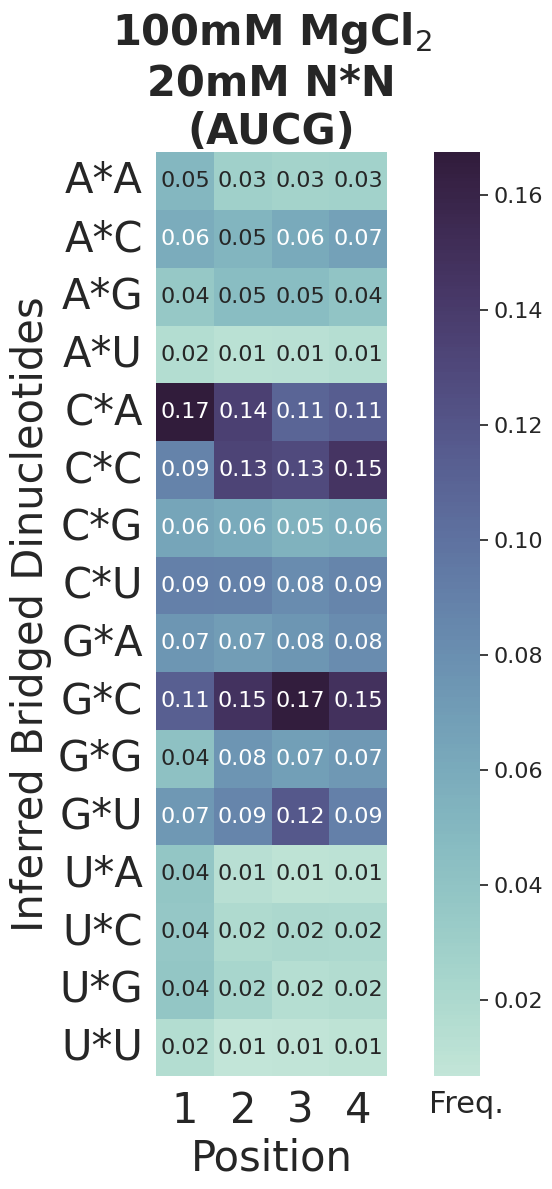

In [ ]:
plt.figure(figsize = (12,12))
ax = sns.heatmap(df_substrate_normalized_s2, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), annot=True, annot_kws={"size": 16}, fmt='.2f', square=True)
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xticks(fontsize=30)
plt.yticks(rotation=360, fontsize=30)
plt.xlabel('Position', fontsize=30)
plt.ylabel('Inferred Bridged Dinucleotides', fontsize=30)
plt.title('100mM MgCl'+r'$_2$'+'\n'+'20mM N*N'+'\n'+'(AUCG)', fontdict={'fontsize': 30}, fontweight="bold")
plt.text(1.18, -0.04, 'Freq.', size=22, transform=ax.transAxes)
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=16)
#plt.savefig('product-diversity/product_diversity_XJb2-2-t-v2-reverse.tiff',dpi=150)

# Mismatched Set

### Product Mismatch Length Count

In [ ]:
# Assuming categorized_pairs is a dictionary with a key 'mismatched' containing mismatched sequence pairs
def extract_length_dependent_mismatch_counts(categorized_pairs):
    # Initialize a counter for each sequence length (0-6)
    length_counts = defaultdict(int)

    # Process only mismatched pairs and count occurrences based on product sequence length
    for _, product in categorized_pairs:
        # Ensure the product sequence length is 0-6
        length = len(product) if len(product) <= 6 else 6
        length_counts[length] += 1

    # Convert the dictionary to a DataFrame for easier visualization and manipulation
    df_length_counts = pd.DataFrame(list(length_counts.items()), columns=['Product Length', 'Count']).sort_values(by='Product Length')
    df_length_counts.set_index('Product Length', inplace=True)

    # Ensuring all lengths (0-6) are represented in the DataFrame
    for i in range(0, 7):
        if i not in df_length_counts.index:
            df_length_counts.loc[i] = [0]
    df_length_counts.sort_index(inplace=True)

    return df_length_counts

In [ ]:
len(categorized_pairs_s2['mismatched'])

68952

In [ ]:
# Example usage
categorized_pairs = categorized_pairs_s2['mismatched']

df_mismatch_counts = extract_length_dependent_mismatch_counts(categorized_pairs)

# Display the DataFrame with mismatch counts by product sequence length
print(df_mismatch_counts)

                Count
Product Length       
0                   0
1               48272
2                8584
3                5491
4                3621
5                1992
6                 992


### Product mismatch sequence space count

In [ ]:
def extract_mismatched_counts_to_df(categorized_pairs):
    # Define all possible mismatched nucleobase pairs with 'T' for DNA context
    mismatched_pairs = ['A:A', 'A:C', 'A:G', 'C:A', 'C:C', 'C:T', 'G:A', 'G:G', 'G:T', 'T:C', 'T:G', 'T:T']

    # Initialize a structure to hold counts for each mismatched pair at each position
    counts = defaultdict(lambda: defaultdict(int))

    # Process only mismatched pairs
    for template, product in categorized_pairs:
        for position, (template_base, product_base) in enumerate(zip(template, product), start=1):
            pair = f'{template_base}:{product_base}'
            if pair in mismatched_pairs:
                counts[pair][position] += 1

    # Convert counts into a DataFrame
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=range(1, 7)).fillna(0).astype(int)

    # Ensure the specific order of rows and replace 'T' with 'U' for display
    df_counts.index = df_counts.index.map(lambda x: x.replace('T', 'U'))
    df_counts = df_counts.reindex([pair.replace('T', 'U') for pair in mismatched_pairs])  # Adjusting 'T' to 'U' in the order list

    return df_counts

In [ ]:
# Example usage
categorized_pairs = categorized_pairs_s2['mismatched']

# Extract mismatched counts and convert to DataFrame
# Note that this pandas dataframe is not normalized to the control template
df_mismatched_counts_raw_s2 = extract_mismatched_counts_to_df(categorized_pairs)

df_mismatched_counts_raw_s2

,1,2,3,4,5,6
A:A,5967,648,527,389,172,68
A:C,5463,689,478,325,112,43
A:G,23330,2695,1656,1020,464,184
C:A,1542,350,261,136,74,47
C:C,1329,364,238,125,74,24
C:U,543,140,79,75,37,32
G:A,604,292,259,166,87,53
G:G,1001,626,385,253,164,104
G:U,2436,1018,463,308,172,66
U:C,1895,655,414,240,106,27


In [ ]:
columns_totals_test = df_mismatched_counts_raw_s2.sum(axis=0)
columns_totals_test

1    50165
2     9484
3     5959
4     3695
5     1859
6      805
dtype: int64

### Product mismatch sequence space counts corrected to control

In [ ]:
df_mismatched_counts_corrected_s2 = df_mismatched_counts_raw_s2.multiply(padded_df_AUCG.values)
df_mismatched_counts_corrected_s2

,1,2,3,4,5,6
A:A,5510.380079,692.550274,571.658105,430.570336,190.410716,73.021894
A:C,5044.948278,736.369041,518.505834,359.731000,123.988373,46.175609
A:G,21544.690339,2880.282389,1796.329833,1129.001908,513.666118,197.588654
C:A,2409.298784,498.009362,388.035344,196.165541,104.596615,65.234155
C:C,2076.496812,517.929737,353.840658,180.299211,104.596615,33.311058
C:U,848.410661,199.203745,117.451311,108.179526,52.298308,44.414744
G:A,594.873148,224.885992,186.074670,115.679449,59.441303,37.270249
G:G,985.874207,482.118600,276.597482,176.306630,112.050273,73.134073
G:U,2399.190379,784.020343,332.635413,214.634158,117.516140,46.412008
U:C,1501.856330,616.126064,408.450454,247.868531,114.522677,29.149949


### Product mismatch sequence space counts corrected and normalized

In [ ]:
columns_totals = df_mismatched_counts_corrected_s2.sum(axis=0)

# Normalize each value by its row's total to get frequencies
normalized_frequencies_df_s2 = df_mismatched_counts_corrected_s2.div(columns_totals, axis=1)

# Display the normalized frequencies DataFrame
normalized_frequencies_df_s2

,1,2,3,4,5,6
A:A,0.115486,0.072752,0.093218,0.112186,0.099069,0.089574
A:C,0.105731,0.077355,0.084550,0.093729,0.064510,0.056642
A:G,0.451530,0.302570,0.292919,0.294163,0.267255,0.242376
C:A,0.050494,0.052315,0.063275,0.051111,0.054421,0.080021
C:C,0.043519,0.054408,0.057699,0.046977,0.054421,0.040862
C:U,0.017781,0.020926,0.019152,0.028186,0.027210,0.054482
G:A,0.012467,0.023624,0.030342,0.030140,0.030927,0.045718
G:G,0.020662,0.050646,0.045103,0.045937,0.058299,0.089712
G:U,0.050282,0.082360,0.054241,0.055923,0.061142,0.056932
U:C,0.031476,0.064723,0.066604,0.064583,0.059585,0.035757


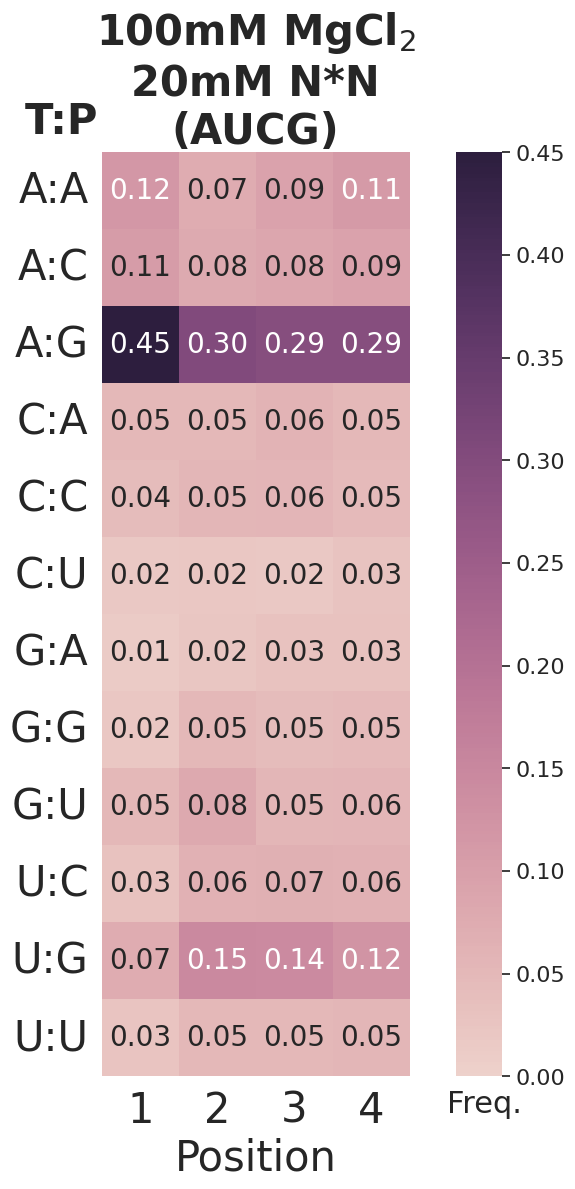

In [ ]:
plt.figure(figsize = (12,12))
ax = sns.heatmap(normalized_frequencies_df_s2.iloc[:, :4], cmap=sns.cubehelix_palette(as_cmap=True), annot=True, annot_kws={"size": 20}, fmt='.2f', square=True, vmin=0, vmax=0.45)
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xticks(fontsize=30)
plt.yticks(rotation=360, fontsize=30)
plt.xlabel('Position', fontsize=30)
plt.ylabel('', fontsize=20);
plt.title('100mM MgCl'+r'$_2$'+'\n'+'20mM N*N'+'\n'+'(AUCG)', fontdict={'fontsize': 30}, fontweight="bold")
plt.text(-0.25, 1.02, 'T:P', size=30, transform=ax.transAxes, fontweight="bold")
plt.text(1.12, -0.04, 'Freq.', size=22, transform=ax.transAxes)
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=16)
#plt.savefig('mismatch/mismatch_XJb2-2-t-v2.tiff', dpi=150)

# Stalling Factor

### Probability of extension

In [ ]:
def calculate_extension_probabilities(pairs):
    # Define known mismatched and complementary pairs
    mismatched_pairs = ['A:A', 'A:C', 'A:G', 'C:A', 'C:C', 'C:U', 'G:A', 'G:G', 'G:U', 'U:C', 'U:G', 'U:U']
    complementary_pairs = ['A:U', 'C:G', 'G:C', 'U:A']

    # Initialize counters for total pairs and extensions
    total_counts = defaultdict(int)
    extension_counts = defaultdict(int)

    for template, product in pairs:
        # Convert T in product to U for RNA representation
        template = template.replace('T', 'U')
        product = product.replace('T', 'U')

        # Record the first template:product pair
        if len(template) > 0 and len(product) > 0:
            first_pair = f"{template[0]}:{product[0]}"
            total_counts[first_pair] += 1

            # Check if there's an extension at the second position of the product
            if len(product) > 1:
                extension_counts[first_pair] += 1

    # Calculate the probability of extension for each template:product pair
    probabilities = {pair: extension_counts[pair] / total_counts[pair] for pair in total_counts}

    # Prepare the results as a pandas DataFrame
    all_pairs = mismatched_pairs + complementary_pairs
    results = {pair: probabilities.get(pair, 0) for pair in all_pairs}
    df_results = pd.DataFrame(list(results.items()), columns=['Template:Product', 'Probability of Extension'])

    return df_results

In [ ]:
# sample 2
pairs = filtered_pairs_s2

df_extension_probability = calculate_extension_probabilities(pairs)
print("Probability of Extension for Each Template:Product Pair at the +2 Position:")
print(df_extension_probability)

Probability of Extension for Each Template:Product Pair at the +2 Position:
   Template:Product  Probability of Extension
0               A:A                  0.032009
1               A:C                  0.049973
2               A:G                  0.012473
3               C:A                  0.041505
4               C:C                  0.126411
5               C:U                  0.051565
6               G:A                  0.124172
7               G:G                  0.042957
8               G:U                  0.067734
9               U:C                  0.085488
10              U:G                  0.079499
11              U:U                  0.050450
12              A:U                  0.311345
13              C:G                  0.467694
14              G:C                  0.410470
15              U:A                  0.452733


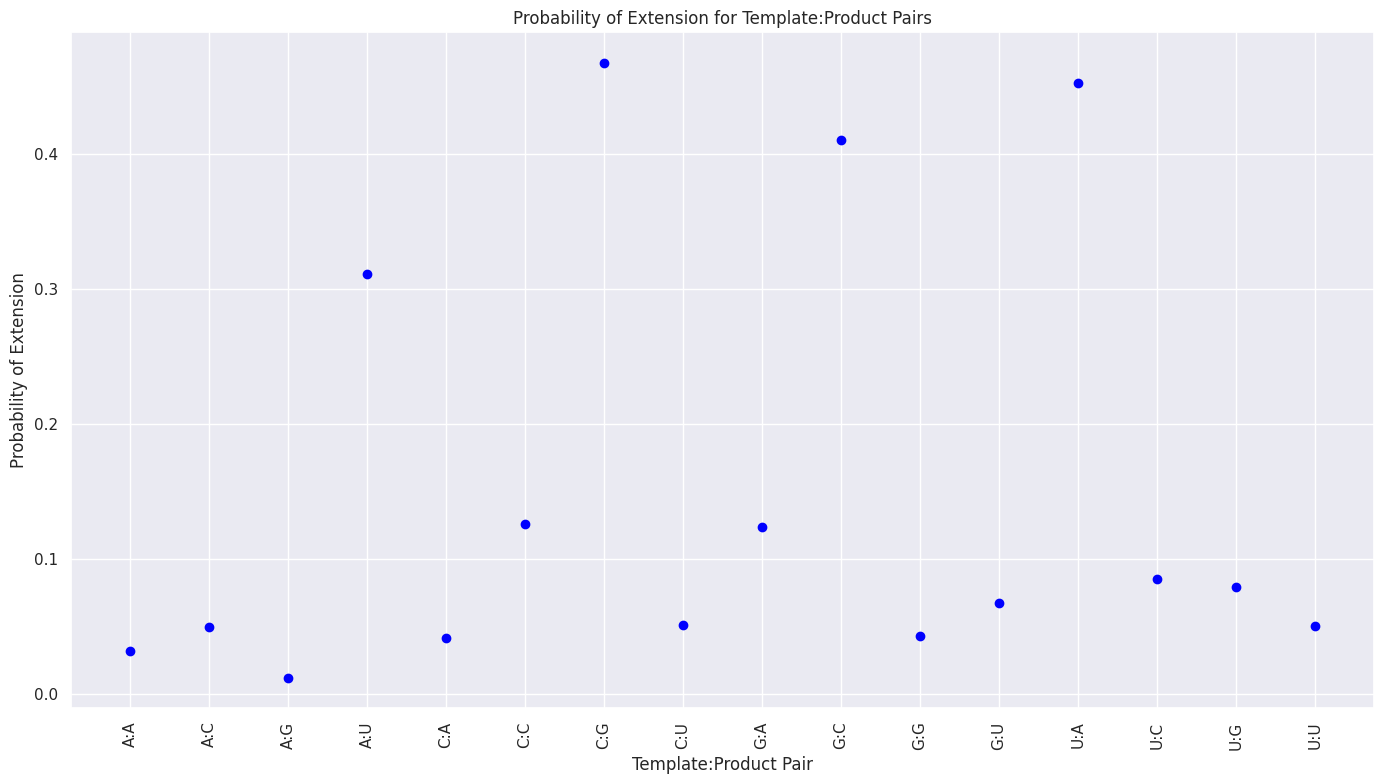

In [ ]:
# generate a scatterplot of the probability of extension for all 16 possible template:product pairs

df_extension_probability_s2 = calculate_extension_probabilities(pairs)  # Use the actual function to populate this DataFrame

# Set the figure size for better readability
plt.figure(figsize=(14, 8))

# Create scatter plot
# Convert 'Template:Product' pairs to categorical data for plotting
categories = df_extension_probability['Template:Product'].astype('category').cat.codes
plt.scatter(categories, df_extension_probability['Probability of Extension'], color='blue')

# Improve x-axis labels to show actual 'Template:Product' pairs instead of numeric categories
plt.xticks(categories, df_extension_probability['Template:Product'], rotation='vertical')

# Adding titles and labels
plt.title('Probability of Extension for Template:Product Pairs')
plt.xlabel('Template:Product Pair')
plt.ylabel('Probability of Extension')
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

### Stalling factor

In [ ]:
 # stalling factor = (probability of extension after a complementary pair) / (probability of extension after a mismatched pair)

 def compute_stalling_factors(df_extension_probability):
    # Define the mismatched and complementary pairs explicitly
    mismatched_to_complementary = {
        'A:A': 'A:U', 'A:C': 'A:U', 'A:G': 'A:U',
        'C:A': 'C:G', 'C:C': 'C:G', 'C:U': 'C:G',
        'G:A': 'G:C', 'G:G': 'G:C', 'G:U': 'G:C',
        'U:C': 'U:A', 'U:G': 'U:A', 'U:U': 'U:A',
    }

    # Convert T to U in the DataFrame for uniformity
   # df_extension_probability['Template:Product'] = df_extension_probability['Template:Product'].str.replace('T', 'U')

    # Initialize a dictionary to store the probabilities for quick access
    probabilities = df_extension_probability.set_index('Template:Product')['Probability of Extension'].to_dict()

    # Calculate stalling factors for all 12 mismatched pairs
    stalling_factors = {}
    for mismatched_pair, complementary_pair in mismatched_to_complementary.items():
        # Calculate the stalling factor
        probability_complementary = probabilities.get(complementary_pair, 0)
        probability_mismatched = probabilities.get(mismatched_pair, 0)
        stalling_factor = (probability_complementary / probability_mismatched) if probability_mismatched else float('inf')
        stalling_factors[mismatched_pair] = stalling_factor

    # Convert the stalling factor results to a DataFrame for easier viewing and analysis
    df_stalling_factors = pd.DataFrame(list(stalling_factors.items()), columns=['Mismatched Pair', 'Stalling Factor'])

    return df_stalling_factors

In [ ]:
df_stalling_factors_s2 = compute_stalling_factors(df_extension_probability_s2)
print("Stalling Factors for Mismatched Pairs:")
print(df_stalling_factors_s2)

Stalling Factors for Mismatched Pairs:
   Mismatched Pair  Stalling Factor
0              A:A         9.726684
1              A:C         6.230325
2              A:G        24.961110
3              C:A        11.268501
4              C:C         3.699793
5              C:U         9.069922
6              G:A         3.305654
7              G:G         9.555367
8              G:U         6.060034
9              U:C         5.295860
10             U:G         5.694838
11             U:U         8.973818


# Probability of Extension for Complementary vs. Mismatched Pairs

In [ ]:
def overall_extension_probabilities(pairs):
    # Define known mismatched and complementary pairs
    mismatched_pairs = ['A:A', 'A:C', 'A:G', 'C:A', 'C:C', 'C:U', 'G:A', 'G:G', 'G:U', 'U:C', 'U:G', 'U:U']
    complementary_pairs = ['A:U', 'C:G', 'G:C', 'U:A']

    # Initialize counters for total pairs and extensions
    total_counts = defaultdict(int)
    extension_counts = defaultdict(int)

    for template, product in pairs:
        # Convert T in product to U for RNA representation
        template = template.replace('T', 'U')
        product = product.replace('T', 'U')

        # Record the first template:product pair
        if len(template) > 0 and len(product) > 0:
            first_pair = f"{template[0]}:{product[0]}"
            total_counts[first_pair] += 1

            # Check if there's an extension at the second position of the product
            if len(product) > 1:
                extension_counts[first_pair] += 1

    # Calculate the probability of extension after a complementary or mismatched pair
    sum_extension_counts_complementary = 0
    sum_total_counts_complementary = 0
    sum_extension_counts_mismatched = 0
    sum_total_counts_mismatched = 0

    for pair in total_counts:
      if pair in mismatched_pairs:
        sum_extension_counts_mismatched += extension_counts[pair]
        sum_total_counts_mismatched += total_counts[pair]
      if pair in complementary_pairs:
        sum_extension_counts_complementary += extension_counts[pair]
        sum_total_counts_complementary += total_counts[pair]


    probability_mismatched = sum_extension_counts_mismatched / sum_total_counts_mismatched
    probability_complemetnary = sum_extension_counts_complementary / sum_total_counts_complementary

    return probability_mismatched, probability_complemetnary

In [ ]:
m_s2, c_s2 = overall_extension_probabilities(filtered_pairs_s2)
print(f"Probability of Extension after a Mismatched Pair: {m_s2:.4f}")
print(f"Probability of Extension after a Complementary Pair: {c_s2:.4f}")

Probability of Extension after a Mismatched Pair: 0.0377
Probability of Extension after a Complementary Pair: 0.4173


## Next Base Sequence Prediction

### LSTM

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def preprocess_sequences(sequences):
    """
    Convert nucleotide sequences to a one-hot encoded format.
    """
    # Mapping for one-hot encoding
    nucleotide_to_index = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
    # Convert sequences to one-hot encoded format
    one_hot_sequences = []
    for seq in sequences:
        one_hot_seq = to_categorical([nucleotide_to_index[nuc] for nuc in seq], num_classes=4)
        one_hot_sequences.append(one_hot_seq)
    return np.array(one_hot_sequences)

In [ ]:
len(filtered_pairs_s2)

633720

In [ ]:
def extract_length2(filtered_pairs):
  trimmed_filtered_pairs = []
  for item in filtered_pairs:
    # check if the product is three-nucleotide long
    if len(item[1]) == 3:
      trimmed_filtered_pairs.append(item)

  template_length2 = [item[0] for item in trimmed_filtered_pairs]
  product_length2 = [item[1] for item in trimmed_filtered_pairs]
  return template_length2, product_length2

In [ ]:
template_length2_s2, product_length2_s2 = extract_length2(filtered_pairs_s2)

In [ ]:
len(template_length2_s2)

17979

In [ ]:
template_sequences = template_length2_s2
product_sequences = product_length2_s2

# Preprocess sequences
X = preprocess_sequences(template_sequences)
y = preprocess_sequences(product_sequences)

# Assuming middle (second) nucleotide in 'y' is what we want to predict, let's prepare the labels accordingly
y_labels = y[:, -2, :]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(4, activation='softmax')  # Output layer for 4 nucleotides
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Predict the next base profile for the test set
predictions = model.predict(X_test)

# Example: Convert predictions to nucleotide distribution
predicted_nucleotide_distribution = np.argmax(predictions, axis=1)

Epoch 1/50
360/360 [==============================] - 5s 7ms/step - loss: 0.7665 - accuracy: 0.7061 - val_loss: 0.4822 - val_accuracy: 0.8401
Epoch 2/50
360/360 [==============================] - 2s 6ms/step - loss: 0.2803 - accuracy: 0.9217 - val_loss: 0.2204 - val_accuracy: 0.9555
Epoch 3/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1859 - accuracy: 0.9593 - val_loss: 0.1966 - val_accuracy: 0.9597
Epoch 4/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1709 - accuracy: 0.9640 - val_loss: 0.2006 - val_accuracy: 0.9572
Epoch 5/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1665 - accuracy: 0.9651 - val_loss: 0.1792 - val_accuracy: 0.9625
Epoch 6/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1618 - accuracy: 0.9664 - val_loss: 0.1757 - val_accuracy: 0.9632
Epoch 7/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1608 - accuracy: 0.9660 - val_loss: 0.1764 - val_accuracy: 0.9632
Epoch 

In [ ]:
from collections import Counter

# Use Counter to count occurrences of each number
number_distribution = Counter(predicted_nucleotide_distribution)

# Dictionary to convert the number back to the nucleobase
index_to_nucleotide = {0: 'A', 1: 'T', 2: 'C', 3: 'G'}

# Printing the distribution
for number in range(4):  # Since we know the array is made of 0, 1, 2, 3
    print(f"Nucleobase {index_to_nucleotide[number]}: {number_distribution[number]} occurrences")

# Print the normalized distribution of each nucleobase in the last position
for number in range(4):
  print(f"Normalized nucleobase distribution is {index_to_nucleotide[number]}: {round(number_distribution[number]/len(predicted_nucleotide_distribution), 2)}")

Nucleobase A: 482 occurrences
Nucleobase T: 132 occurrences
Nucleobase C: 1913 occurrences
Nucleobase G: 1069 occurrences
Normalized nucleobase distribution is A: 0.13
Normalized nucleobase distribution is T: 0.04
Normalized nucleobase distribution is C: 0.53
Normalized nucleobase distribution is G: 0.3


## GRU

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split

# Assuming template_sequences and product_sequences are provided
template_sequences = template_length2_s2  # Placeholder variable
product_sequences = product_length2_s2    # Placeholder variable

# Preprocess sequences
X = preprocess_sequences(template_sequences)
y = preprocess_sequences(product_sequences)

# Assuming middle (second) nucleotide in 'y' is what we want to predict, let's prepare the labels accordingly
y_labels = y[:, -2, :]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Define the GRU model
model2 = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(4, activation='softmax')  # Output layer for 4 nucleotides
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Predict the next base profile for the test set
predictions = model2.predict(X_test)

# Convert predictions to nucleotide distribution
predicted_nucleotide_distribution = np.argmax(predictions, axis=1)

Epoch 1/50
360/360 [==============================] - 5s 7ms/step - loss: 0.7506 - accuracy: 0.7180 - val_loss: 0.3908 - val_accuracy: 0.8916
Epoch 2/50
360/360 [==============================] - 2s 6ms/step - loss: 0.2556 - accuracy: 0.9339 - val_loss: 0.2170 - val_accuracy: 0.9531
Epoch 3/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1850 - accuracy: 0.9612 - val_loss: 0.1925 - val_accuracy: 0.9600
Epoch 4/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1711 - accuracy: 0.9646 - val_loss: 0.1972 - val_accuracy: 0.9621
Epoch 5/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1644 - accuracy: 0.9665 - val_loss: 0.1774 - val_accuracy: 0.9639
Epoch 6/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1622 - accuracy: 0.9662 - val_loss: 0.1753 - val_accuracy: 0.9649
Epoch 7/50
360/360 [==============================] - 2s 6ms/step - loss: 0.1601 - accuracy: 0.9670 - val_loss: 0.1726 - val_accuracy: 0.9628
Epoch 